<a href="https://colab.research.google.com/github/AmanPriyanshu/Natural-Language-Processing/blob/master/VectorSpace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DOWNLOAD DATASET:

In [1]:
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/sentiment140-subset.csv.zip -P data
!unzip -n -d data data/sentiment140-subset.csv.zip

--2020-09-17 17:41:06--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/sentiment140-subset.csv.zip
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17927149 (17M) [application/zip]
Saving to: ‘data/sentiment140-subset.csv.zip’

sentiment140-subset 100%[===================>]  17.10M  6.78MB/s    in 2.5s    

2020-09-17 17:41:10 (6.78 MB/s) - ‘data/sentiment140-subset.csv.zip’ saved [17927149/17927149]

Archive:  data/sentiment140-subset.csv.zip
  inflating: data/sentiment140-subset.csv  


## IMPORTS:

In [2]:
import nltk
import pandas as pd
import numpy as np
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
from tqdm import tqdm, trange
import string
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from sklearn.neighbors import KNeighborsClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Only importing 30,000 values since this is more of practice and demo for refrence

In [3]:
df = pd.read_csv("data/sentiment140-subset.csv", nrows=5000)
print(df.head())

   polarity                                               text
0         0                      @kconsidder You never tweet  
1         0                 Sick today  coding from the couch.
2         1  @ChargerJenn Thx for answering so quick,I was ...
3         1  Wii fit says I've lost 10 pounds since last ti...
4         0  @MrKinetik Not a thing!!!  I don't really have...


### Let's count positives and negatives

In [4]:
df.polarity.value_counts()

1    2522
0    2478
Name: polarity, dtype: int64

### Let's take a look:

In [5]:
df = df.values
print(df)

[[0 '@kconsidder You never tweet  ']
 [0 'Sick today  coding from the couch.']
 [1
  '@ChargerJenn Thx for answering so quick,I was afraid I was gonna crash twitter with all the spamming I did 2 RR..sorry bout that ']
 ...
 [1
  '@chrissypoofs i emailed you on facebook your new career.. but you can to start TTC twins or more  get to it!! haa haa']
 [1
  '3 people asked me last night-its friday night&amp;no tweets from you-whats up?  people DO care ']
 [0
  'is at work. It looks like it going to be a beautiful day. Today is the last day I see my husband for 5 weeks ']]


In [6]:
polarity = df.T[0].flatten()
tweets = df.T[1].flatten()

In [7]:
tweets

array(['@kconsidder You never tweet  ',
       'Sick today  coding from the couch.',
       '@ChargerJenn Thx for answering so quick,I was afraid I was gonna crash twitter with all the spamming I did 2 RR..sorry bout that ',
       ...,
       '@chrissypoofs i emailed you on facebook your new career.. but you can to start TTC twins or more  get to it!! haa haa',
       '3 people asked me last night-its friday night&amp;no tweets from you-whats up?  people DO care ',
       'is at work. It looks like it going to be a beautiful day. Today is the last day I see my husband for 5 weeks '],
      dtype=object)

## PREPROCESSING:

In [8]:
def stopwords_punctuation(arr):
  new_arr = []
  diction = {}
  for p in string.punctuation:
    diction.update({p:' '})
  for s in tqdm(arr, desc='Punctuation'):
    s = s.translate(str.maketrans(diction))
    new_arr.append(' '.join([i for i in s.split() if i not in stopwords.words('english')]))
  new_arr = np.array(new_arr)
  return new_arr

In [9]:
def stemming_lowercase(arr):
  porter = PorterStemmer()
  stemmed_arr = []
  for s in tqdm(arr, desc='Stemming'):
    s = s.lower()
    stemmed_arr.append(' '.join([porter.stem(word) for word in s.split()]))
  stemmed_arr = np.array(stemmed_arr)
  return stemmed_arr

In [10]:
tweets = stopwords_punctuation(tweets)
tweets = stemming_lowercase(tweets)

Stemming: 100%|██████████| 5000/5000 [00:00<00:00, 6382.38it/s]


## CREATING A Word to Doc simple embed:

In [11]:
def vector_space_generator(arr):
  vocab = []
  for s in tqdm(arr, desc='Defining a Vocab'):
    s = s.split()
    for w in s:
      if w not in vocab:
        vocab.append(w)
  vocab = vocab[:len(vocab)//2]
  vector_space = []
  for s in tqdm(arr, desc='Generating Vector Space'):
    s = s.split()
    row = [0 for _ in range(len(vocab))]
    for w in s:
      try:
        row[vocab.index(w)] += 1
      except:
        pass
    vector_space.append(row)
  vector_space = np.array(vector_space)
  return vector_space

In [12]:
vector_space = vector_space_generator(tweets)

Generating Vector Space: 100%|██████████| 5000/5000 [00:02<00:00, 2045.36it/s]


### NORMALIZING:

In [13]:
def normalize(space):
  space = space.T
  normalized_space = []
  for col in tqdm(space):
    normalized_space.append((col - np.mean(col))/np.std(col))
  normalized_space = np.array(normalized_space)
  return normalized_space.T

In [14]:
vector_space_norm = normalize(vector_space)

100%|██████████| 4977/4977 [00:00<00:00, 6767.32it/s]


In [15]:
def pca_generator(space, dims=2):
  pca = PCA(n_components=dims)
  pca.fit(space)
  projection_matrix = pca.transform(space)
  print("Cummulative Explained Variance Ratio", sum(pca.explained_variance_ratio_))
  return projection_matrix

In [16]:
pca_matrix = pca_generator(vector_space_norm)

Cummulative Explained Variance Ratio 0.005638252228048216


## PLOTTING:

In [17]:
colors = ['r', 'g']

In [18]:
from matplotlib import pyplot as plt

100%|██████████| 5000/5000 [00:00<00:00, 617190.62it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  if sys.path[0] == '':


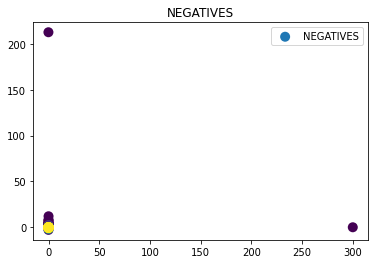

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


<Figure size 432x288 with 0 Axes>

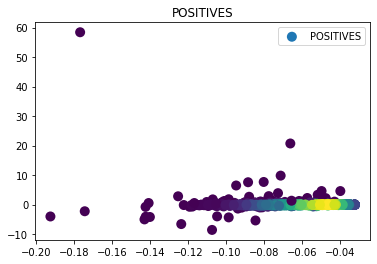

In [19]:
positives = []
negatives = []
for plot, polar in tqdm(zip(pca_matrix, polarity), total=len(polarity)):
  if polar == 1:
    positives.append(plot)
  else:
    negatives.append(plot)
negatives = np.array(negatives)
xy = np.vstack([negatives.T[0], negatives.T[1]])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
ax.scatter(negatives.T[0], negatives.T[1], c=z, s=100, edgecolor='', label='NEGATIVES')
plt.title("NEGATIVES")
plt.legend()
plt.show()
plt.clf()

positives = np.array(positives)
xy = np.vstack([positives.T[0], positives.T[1]])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
ax.scatter(positives.T[0], positives.T[1], c=z, s=100, edgecolor='', label='POSITIVES')
plt.title("POSITIVES")
plt.legend()
plt.show()

### Let's see of KNN can classify:

In [20]:
labels = [i for i in polarity]
pca_matrix = pca_generator(vector_space_norm, 250)

Cummulative Explained Variance Ratio 0.25260995982430257


In [21]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(pca_matrix[:pca_matrix.shape[0]//2], labels[:pca_matrix.shape[0]//2])
results = neigh.score(pca_matrix, labels)
print("Accuracy:", results)

Accuracy: 0.7748
